# Scalar Quantization of Digital Signals

## A.  Uniform Quantization

### A.a. Midtread ("round") Quantization

#### A.a.1. No quantization ($\Delta=1$)

In [438]:
quantization_step = 1 # Delta

In [439]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.axes as ax
import math
import numpy as np

In [440]:
x_plot = np.linspace(-8, 8, 500) # Input samples

In [441]:
y_plot = np.round(x_plot/quantization_step) # Quantized samples

In [442]:
def plot_quantizer(x_plot, y_plot, title):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.set_title(title)
    ax.spines['left'].set_position('zero')
    ax.spines['right'].set_color('none')
    ax.spines['bottom'].set_position('zero')
    ax.spines['top'].set_color('none')
    ax.xaxis.set_label_coords(1,0.40)
    ax.xaxis.set_label_text('Input')
    ax.yaxis.set_label_coords(0.45,.9)
    ax.yaxis.set_label_text('Output')

    ticks = np.arange(-8, 9, 1)
    ax.set_xticks(ticks)
    ax.set_yticks(ticks)

    ax.grid()
    ax.plot(x_plot, y_plot)

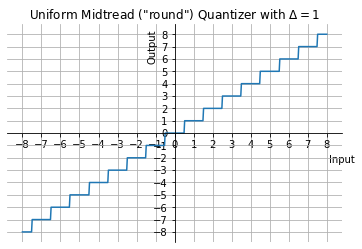

In [443]:
plot_quantizer(x_plot, y_plot, 'Uniform Midtread ("round") Quantizer with $\Delta={}$'.format(quantization_step))

In [484]:
def plot_quantization_error(x, error, title):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.set_title(title)
    ax.grid()
    ax.xaxis.set_label_text('Input')
    ax.yaxis.set_label_text('Error')
    ax.plot(x, error)

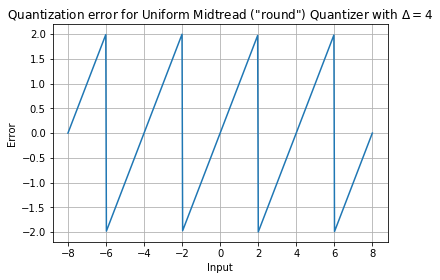

In [485]:
x_plot_recons = y_plot * quantization_step
error_plot = x_plot-x_plot_recons
plot_quantization_error(x_plot, error_plot, 'Quantization error for Uniform Midtread ("round") Quantizer with $\Delta={}$'.format(quantization_step))

#### Compute output for each possible input using 16 bits

In [446]:
x = np.linspace(-32768, 32767, 65536).astype(np.int16) # Input samples

In [447]:
x

array([-32768, -32767, -32766, ...,  32765,  32766,  32767], dtype=int16)

In [448]:
y = np.round(x/quantization_step).astype(np.int16) # Quantized samples

In [449]:
y

array([-32768, -32767, -32766, ...,  32765,  32766,  32767], dtype=int16)

In [450]:
y[32750:32790]

array([-18, -17, -16, -15, -14, -13, -12, -11, -10,  -9,  -8,  -7,  -6,
        -5,  -4,  -3,  -2,  -1,   0,   1,   2,   3,   4,   5,   6,   7,
         8,   9,  10,  11,  12,  13,  14,  15,  16,  17,  18,  19,  20,
        21], dtype=int16)

In [455]:
def print_center(x, y, n):
    offset = 32768-n//2
    for i in range(n):
        input = int(x[i+offset])
        output = int(y[i+offset])
        print(f"{input:>6d} {output:>6d}")
        #print(x[i+offset], y[i+offset])

In [456]:
print(f"{'Input':>6s} {'Output':>6s}")
print_center(x, y, 16)

 Input Output
    -8     -8
    -7     -7
    -6     -6
    -5     -5
    -4     -4
    -3     -3
    -2     -2
    -1     -1
     0      0
     1      1
     2      2
     3      3
     4      4
     5      5
     6      6
     7      7


Notice that for $\Delta=1$, the number of bits for representing the input and the output is the same. $65536$ different inputs are represented by $65536$ outputs.

#### A.a.2. Quantization with quantization step $\Delta=2$

In [457]:
quantization_step = 2 # Delta

In [458]:
x_plot = np.linspace(-8, 8, 500) # Input samples

In [459]:
y_plot = np.round(x_plot/quantization_step) # Quantized samples

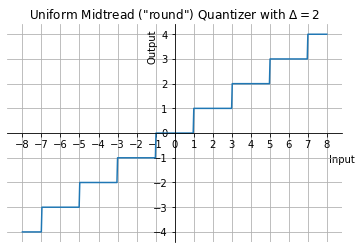

In [460]:
plot_quantizer(x_plot, y_plot, 'Uniform Midtread ("round") Quantizer with $\Delta={}$'.format(quantization_step))

In [462]:
x = np.linspace(-32768, 32767, 65536).astype(np.int16) # Input samples
y = np.round(x/quantization_step).astype(np.int16) # Quantized samples

In [465]:
print_center(x, y, 32)

   -16     -8
   -15     -8
   -14     -7
   -13     -6
   -12     -6
   -11     -6
   -10     -5
    -9     -4
    -8     -4
    -7     -4
    -6     -3
    -5     -2
    -4     -2
    -3     -2
    -2     -1
    -1      0
     0      0
     1      0
     2      1
     3      2
     4      2
     5      2
     6      3
     7      4
     8      4
     9      4
    10      5
    11      6
    12      6
    13      6
    14      7
    15      8


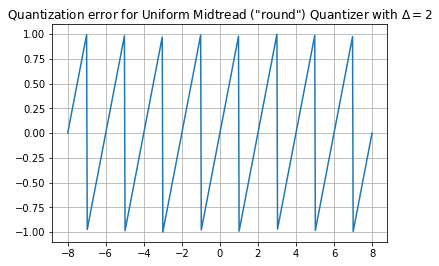

In [466]:
x_plot_recons = y_plot * quantization_step
error_plot = x_plot-x_plot_recons
plot_quantization_error(x_plot, error_plot, 'Quantization error for Uniform Midtread ("round") Quantizer with $\Delta={}$'.format(quantization_step))

#### A.a.3. Quantization with quantization step $\Delta=3$

In [467]:
quantization_step = 3 # Delta

In [468]:
x_plot = np.linspace(-8, 8, 500) # Input samples

In [469]:
y_plot = np.round(x_plot/quantization_step) # Quantized samples

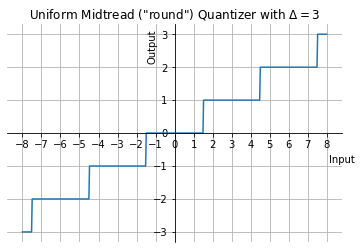

In [470]:
plot_quantizer(x_plot, y_plot, 'Uniform Midtread ("round") Quantizer with $\Delta={}$'.format(quantization_step))

In [472]:
x = np.linspace(-32768, 32767, 65536).astype(np.int16) # Input samples
y = np.round(x/quantization_step).astype(np.int16) # Quantized samples

In [473]:
print_center(x, y, 32)

   -16     -5
   -15     -5
   -14     -5
   -13     -4
   -12     -4
   -11     -4
   -10     -3
    -9     -3
    -8     -3
    -7     -2
    -6     -2
    -5     -2
    -4     -1
    -3     -1
    -2     -1
    -1      0
     0      0
     1      0
     2      1
     3      1
     4      1
     5      2
     6      2
     7      2
     8      3
     9      3
    10      3
    11      4
    12      4
    13      4
    14      5
    15      5


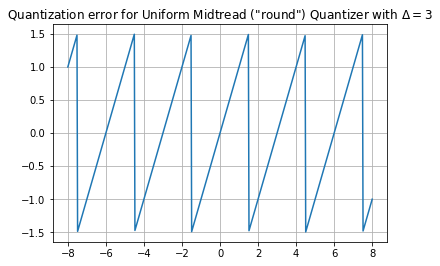

In [474]:
x_plot_recons = y_plot * quantization_step
error_plot = x_plot-x_plot_recons
plot_quantization_error(x_plot, error_plot, 'Quantization error for Uniform Midtread ("round") Quantizer with $\Delta={}$'.format(quantization_step))

### A.4. Quantization with quantization step $\Delta=4$

In [475]:
quantization_step = 4 # Delta

In [476]:
x_plot = np.linspace(-8, 8, 500) # Input samples

In [477]:
y_plot = np.round(x_plot/quantization_step) # Quantized samples

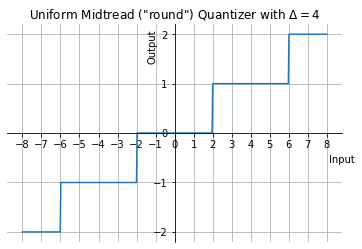

In [478]:
plot_quantizer(x_plot, y_plot, 'Uniform Midtread ("round") Quantizer with $\Delta={}$'.format(quantization_step))

In [479]:
x = np.linspace(-32768, 32767, 65536).astype(np.int16) # Input samples
y = np.round(x/quantization_step).astype(np.int16) # Quantized samples

In [480]:
print_center(x, y, 32)

   -16     -4
   -15     -4
   -14     -4
   -13     -3
   -12     -3
   -11     -3
   -10     -2
    -9     -2
    -8     -2
    -7     -2
    -6     -2
    -5     -1
    -4     -1
    -3     -1
    -2      0
    -1      0
     0      0
     1      0
     2      0
     3      1
     4      1
     5      1
     6      2
     7      2
     8      2
     9      2
    10      2
    11      3
    12      3
    13      3
    14      4
    15      4


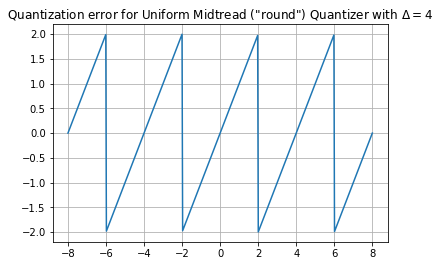

In [481]:
x_plot_recons = y_plot * quantization_step
error_plot = x_plot-x_plot_recons
plot_quantization_error(x_plot, error_plot, 'Quantization error for Uniform Midtread ("round") Quantizer with $\Delta={}$'.format(quantization_step))

### A.b. Deadzone ("truncation") Quantization

#### A.b.1. Quantization with quantization step $\Delta=2$

In [486]:
quantization_step = 2 # Delta

In [487]:
x_plot = np.linspace(-8, 8, 500) # Input samples

In [488]:
y_plot = (x_plot/quantization_step).astype(np.int16)  # Quantized samples

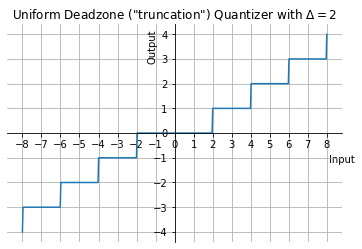

In [489]:
plot_quantizer(x_plot, y_plot, 'Uniform Deadzone ("truncation") Quantizer with $\Delta={}$'.format(quantization_step))

In [490]:
x = np.linspace(-32768, 32767, 65536).astype(np.int16) # Input samples
y = (x/quantization_step).astype(np.int16) # Quantized samples

In [491]:
print_center(x, y, 32)

   -16     -8
   -15     -7
   -14     -7
   -13     -6
   -12     -6
   -11     -5
   -10     -5
    -9     -4
    -8     -4
    -7     -3
    -6     -3
    -5     -2
    -4     -2
    -3     -1
    -2     -1
    -1      0
     0      0
     1      0
     2      1
     3      1
     4      2
     5      2
     6      3
     7      3
     8      4
     9      4
    10      5
    11      5
    12      6
    13      6
    14      7
    15      7


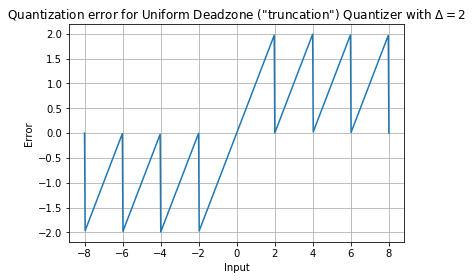

In [492]:
x_plot_recons = y_plot * quantization_step
error_plot = x_plot-x_plot_recons
plot_quantization_error(x_plot, error_plot, 'Quantization error for Uniform Deadzone ("truncation") Quantizer with $\Delta={}$'.format(quantization_step))

## B. Logaritmic quantization

In [493]:
x_plot = np.linspace(-8, 8, 500) # Input samples

mu = 1.0
x_max = 16
y_plot = (np.round(x_max*np.log(1+mu*np.abs(x_plot)/x_max)/np.log(1+mu)*np.sign(x_plot))).astype(int)

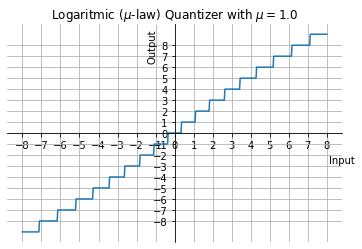

In [495]:
plot_quantizer(x_plot, y_plot, 'Logaritmic ($\mu$-law) Quantizer with $\mu={}$'.format(mu))

In [ ]:
x_plot_recos = (x_max/mu)*((1+mu)**(np.abs(_y)/x_max)-1)*np.sign(_y)

# Which is better?

In [290]:
def compute_average_energy(x):
    return np.sum(x.astype(np.double)*x.astype(np.double))/len(x)

In [291]:
def RMSE(x, y):
    error_signal = x - y
    return math.sqrt(compute_average_energy(error_signal))

In [292]:
# https://stackoverflow.com/questions/15450192/fastest-way-to-compute-entropy-in-python
def entropy_in_bits_per_symbol(sequence_of_symbols):
    value, counts = np.unique(sequence_of_symbols, return_counts = True)
    probs = counts / len(sequence_of_symbols)
    n_classes = np.count_nonzero(probs)

    if n_classes <= 1:
        return 0

    entropy = 0.
    for i in probs:
        entropy -= i * math.log(i, 2)

    return entropy

In [309]:
def midtread_quantization(quantization_step):
    x = np.linspace(-32768, 32767, 65536).astype(np.int16) # Input samples
    y = np.round(x/quantization_step).astype(np.int16) # Quantized samples
    x_recons = y*quantization_step # Reconstructed samples
    return x, y, x_recons

In [318]:
def deadzone_quantization(quantization_step):
    x = np.linspace(-32768, 32767, 65536).astype(np.int16) # Input samples
    y = (x/quantization_step).astype(np.int16) # Quantized samples
    x_recons = y*quantization_step # Reconstructed samples
    return x, y, x_recons

In [340]:
def generate_RD_curve_midtread(x, y, x_recons):
    RD_midtread_points = []
    for i in range(1, 32768, 32):
        x, y, x_recons = midtread_quantization(i)
        rate = entropy_in_bits_per_symbol(y)
        distortion = RMSE(x, x_recons)
        RD_midtread_points.append((rate, distortion))
    return RD_midtread_points

In [344]:
def generate_RD_curve_deadzone(x, y, x_recons):
    RD_deadzone_points = []
    for i in range(1, 32768, 32):
        x, y, x_recons = deadzone_quantization(i)
        rate = entropy_in_bits_per_symbol(y)
        distortion = RMSE(x, x_recons)
        RD_deadzone_points.append((rate, distortion))
    return RD_deadzone_points

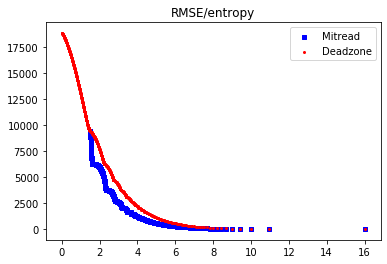

In [345]:
RD_midtread_points = generate_RD_curve_midtread(x, y, x_recons)
RD_deadzone_points = generate_RD_curve_deadzone(x, y, x_recons)
plt.title("RMSE/entropy")
plt.scatter(*zip(*RD_midtread_points), s=12, c='b', marker="s", label='Mitread')
plt.scatter(*zip(*RD_deadzone_points), s=4, c='r', marker="o", label='Deadzone')
plt.legend(loc='upper right')
plt.show()

In [387]:
import sounddevice as sd
fs = 44100
duration = 5.0  # seconds
x = sd.rec(int(duration * fs), samplerate=fs, channels=1, dtype=np.int16)
print("Speak!")
while sd.wait():
    pass
print("done")

Speak!
done


In [388]:
print(x.max(), x.min())

32767 -32768


In [389]:
sd.play(x)

In [390]:
def _midtread_quantization(x, quantization_step):
    y = np.round(x/quantization_step).astype(np.int16) # Quantized samples
    x_recons = y*quantization_step # Reconstructed samples
    return y, x_recons

In [391]:
def _deadzone_quantization(x, quantization_step):
    y = (x/quantization_step).astype(np.int16) # Quantized samples
    x_recons = y*quantization_step # Reconstructed samples
    return y, x_recons

In [392]:
def _generate_RD_curve_midtread(x, y, x_recons):
    RD_midtread_points = []
    for i in range(1, 32768, 32):
        y, x_recons = _midtread_quantization(x, i)
        rate = entropy_in_bits_per_symbol(y)
        distortion = RMSE(x, x_recons)
        RD_midtread_points.append((rate, distortion))
    return RD_midtread_points

In [393]:
def _generate_RD_curve_deadzone(x, y, x_recons):
    RD_points = []
    for i in range(1, 32768, 32):
        y, x_recons = _deadzone_quantization(x, i)
        rate = entropy_in_bits_per_symbol(y)
        distortion = RMSE(x, x_recons)
        RD_points.append((rate, distortion))
    return RD_points

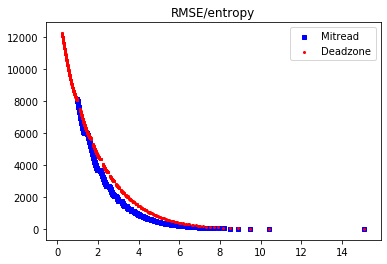

In [394]:
RD_midtread_points = _generate_RD_curve_midtread(x, y, x_recons)
RD_deadzone_points = _generate_RD_curve_deadzone(x, y, x_recons)
plt.title("RMSE/entropy")
plt.scatter(*zip(*RD_midtread_points), s=12, c='b', marker="s", label='Mitread')
plt.scatter(*zip(*RD_deadzone_points), s=4, c='r', marker="o", label='Deadzone')
plt.legend(loc='upper right')
plt.show()

### Rate/Distortion of an Uniform Midtread Quantizer with $\Delta=2$

In [305]:
quantization_step = 333
x = np.linspace(-32768, 32767, 65536).astype(np.int16) # Input samples
y = np.round(x/quantization_step).astype(np.int16) # Quantized samples
x_recons = y*quantization_step # Reconstructed samples

In [306]:
rate = entropy_in_bits_per_symbol(y)
distortion = RMSE(x, x_recons)
print("rate =", rate, "bits/sample")
print("distortion =", distortion)
rate/distortion

rate = 7.621980294866581 bits/sample
distortion = 96.05912311205344


0.07934676111893613

### Rate/Distortion of an Uniform Deadzone Quantizer with $\Delta=2$

In [307]:
quantization_step = 333
x = np.linspace(-32768, 32767, 65536).astype(np.int16) # Input samples
y = (x/quantization_step).astype(np.int16) # Quantized samples
x_recons = y*quantization_step # Reconstructed samples

In [308]:
rate = entropy_in_bits_per_symbol(y)
distortion = RMSE(x, x_recons)
print("rate =", rate, "bits/sample")
print("distortion =", distortion)
rate/distortion

rate = 7.615864985208631 bits/sample
distortion = 191.49587163633518


0.039770387320264125

### Signal Noise Ratio of an Uniform Deadzone Quantizer with $\Delta=2$

In [267]:
quantization_step = 2
x = np.linspace(-32768, 32767, 65536).astype(np.int16) # Input samples
y = (x/quantization_step).astype(np.int16) # Quantized samples
x_recons = y*quantization_step # Reconstructed samples

In [268]:
compute_SNR(x, x_recons)

signal energy = 357913941.5
error energy = 0.5


203.88950309155857

### Signal Noise Ratio of an Uniform Midtread Quantizer with $\Delta=333$

In [269]:
quantization_step = 333
x = np.linspace(-32768, 32767, 65536).astype(np.int16) # Input samples
y = np.round(x/quantization_step).astype(np.int16) # Quantized samples
x_recons = y*quantization_step # Reconstructed samples

In [270]:
compute_SNR(x, x_recons)

signal energy = 357913941.5
error energy = 9227.35513305664


105.65875393294091

### Signal Noise Ratio of an Uniform Deadzone Quantizer with $\Delta=333$

In [271]:
quantization_step = 333
x = np.linspace(-32768, 32767, 65536).astype(np.int16) # Input samples
y = (x/quantization_step).astype(np.int16) # Quantized samples
x_recons = y*quantization_step # Reconstructed samples

In [272]:
compute_SNR(x, x_recons)

signal energy = 357913941.5
error energy = 36670.668853759766


91.8607062788887

In [281]:
print(entropy_in_bits_per_symbol(x))

16.0


In [282]:
print(entropy_in_bits_per_symbol(y))

7.615864985208631


In [199]:

def compute_SNR(x, y):
    signal_energy = compute_average_energy(x)
    error_energy = compute_average_energy(x-y)
    print("signal energy =", signal_energy)
    print("error energy =", error_energy)
    return 10*math.log(signal_energy/error_energy)

In [266]:
compute_SNR(x, x_recons)

signal energy = 357913941.5
error energy = 0.5


203.88950309155857

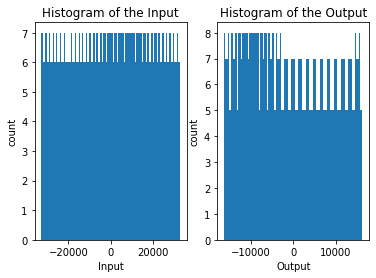

In [117]:
plot_histograms(x, y, 10000)

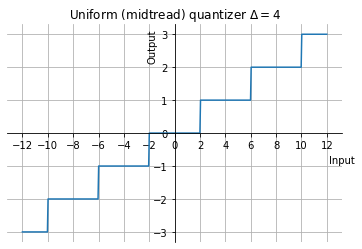

In [4]:
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.axes as ax

quantization_step = 4

fig = plt.figure()
x = np.linspace(-12, 12, 500)
y = np.round(x/quantization_step)

ax = fig.add_subplot(111)
ax.set_title('Uniform (midtread) quantizer $\Delta=4$')
ax.spines['left'].set_position('zero')
ax.spines['right'].set_color('none')
ax.spines['bottom'].set_position('zero')
ax.spines['top'].set_color('none')
ax.xaxis.set_label_coords(1,0.40)
ax.xaxis.set_label_text('Input')
ax.yaxis.set_label_coords(0.45,.9)
ax.yaxis.set_label_text('Output')

x_ticks = np.arange(-12, 13, 2)
y_ticks = np.arange(-12, 13, 1)
ax.set_xticks(x_ticks)
ax.set_yticks(y_ticks)

ax.grid()
ax.plot(x, y)

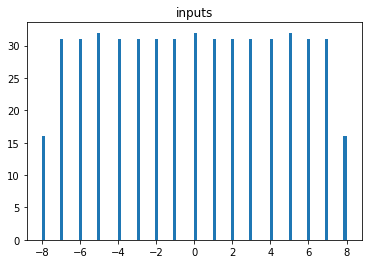

In [32]:
plt.hist(y, bins = 100) 
plt.title("inputs") 
plt.show()

In [73]:
def plot_histograms(x, y, bins):
    fig = plt.figure()

    ax = fig.add_subplot(121)
    ax.hist(x, bins=bins)
    ax.set_title('Histogram of the Input')
    ax.xaxis.set_label_text('Input')
    ax.yaxis.set_label_text('count')

    ax = fig.add_subplot(122)
    ax.hist(y, bins=bins)
    ax.set_title('Histogram of the Output')
    ax.xaxis.set_label_text('Output')
    ax.yaxis.set_label_text('count')

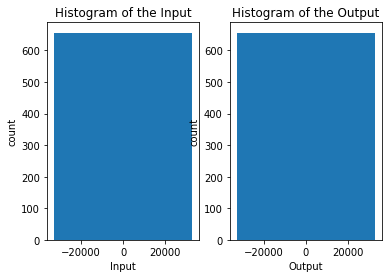

In [74]:
plot_histograms(x, y, bins=100)